# Import all the Important Packages

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Amazon Fine Food Reviews 
#Packages used 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
import string 


#Modules which are to be imported from sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Modules which are to be imported from sklearn.metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

#Modules which are to be imported from nltk

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import pickle

from tqdm import tqdm
import os

##  Exploratory Data Analysis

In [2]:
#Open an connection to the DB from python

con = sqlite3.connect('database.sqlite')

In [3]:
#Filter the data set which contains score of 3 i.e. neutral ratings
filtered_data=pd.read_sql_query('''
SELECT * from 
Reviews
WHERE Score!=3
'''
,con
)

In [4]:
# Function to map the scores with values of 4 and 5 to Positive and 1 and 2 to negative 

def partioner(x):
    if x<3:
        return 0
    else:
        return 1
    

In [5]:
filter_score=filtered_data['Score']
filter_score=filter_score.map(partioner)
filtered_data['Score']=filter_score

filtered_data.shape

(525814, 10)

In [6]:
#Sort data in ascending order based on the values of ProductId Column

sort_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)

sort_data.shape

(525814, 10)

In [7]:
#Remove the duplicates from the sorted data set 

sort_data=sort_data.drop_duplicates(subset=('UserId','ProfileName','Time','Text'),keep='first',inplace=False)

sort_data.shape

(364173, 10)

In [8]:
sort_data=sort_data[sort_data['HelpfulnessNumerator']<=sort_data['HelpfulnessDenominator']]

sort_data.shape

(364171, 10)

In [9]:
#Percentage of points remaining after doing Data Cleansing 
(sort_data['Id'].count()) / (filtered_data['Id'].count()) * 100

69.25852107399194

In [10]:
sort_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [11]:
#Select top 5k points based on timebased sampling

sort_data=sort_data.sort_values('Time',axis=0,ascending=True)

In [12]:
a=sort_data[sort_data['Score']==1].sample(n=2500)

b=sort_data[sort_data['Score']==0].sample(n=2500)

sort_data=a.append(b)

In [13]:
sort_data.shape

(5000, 10)

In [14]:
sort_data['Score'].value_counts()

1    2500
0    2500
Name: Score, dtype: int64

## Text Preprocessing:


In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in sort_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(len(re.findall('<.*?>', sent)))
        print(i)
        print(sent)
        break
    i += 1;

10
0
I've tried some options on amazon.com such as Jack Link's Turkey Jerky and Turkey Nuggets, Snackmasters Range Brown Turkey Jerky, Golden Valley Natural Turkey Jerky, among others from various retail outlets. Totally, I have had ~7 different brands of turkey jerky and ~8 of the beef variety .  Among turkey, Oberto is my favorite by far.<br /><br />Given that jerky is made by a dehydration process, dryness is inherent to jerky as a food.  Also, turkey is a dryer meat than beef (the most common jerky) and I've found turkey jerky to be, on average, dryer than beef jerky.  I prefer my jerky relatively moist.<br /><br />Oberto Turkey Jerky is by far the most moist jerky I've had (aside from the Oberto Pork brand). The package usually has very large strips that hold their water content for greater lengths of time.  The other brands I've tried are broken into small pieces and are very chewy & dry in comparison.  Another key aspect is the flavoring.  This product is well-flavored whereas o

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushiknaagr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 314k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(sort_data['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (sort_data['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(sort_data['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    sort_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    sort_data['CleanedText']=sort_data['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    sort_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

# Featurization

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

## BAG OF WORDS

In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 9636)
the number of unique words  9636


In [21]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 1136), (b'tast', 1061), (b'good', 930), (b'love', 928), (b'flavor', 857), (b'great', 845), (b'use', 798), (b'one', 766), (b'product', 755), (b'tri', 712), (b'tea', 711), (b'make', 652), (b'get', 591), (b'food', 537), (b'coffe', 535), (b'buy', 454), (b'find', 443), (b'amazon', 439), (b'realli', 433), (b'would', 427)]
Most Common Negative Words :  [(b'tast', 1456), (b'like', 1382), (b'product', 1185), (b'one', 886), (b'flavor', 853), (b'would', 777), (b'tri', 776), (b'coffe', 693), (b'good', 653), (b'use', 642), (b'buy', 600), (b'get', 592), (b'order', 583), (b'tea', 549), (b'box', 525), (b'even', 482), (b'dont', 476), (b'amazon', 455), (b'food', 447), (b'time', 439)]


## Bi-Grams and n-Grams.

In [22]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 2957)
the number of unique words including both unigrams and bigrams  2957


## TF-IDF

In [23]:
#TF-IDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 9636)
the number of unique words including both unigrams and bigrams  9636


In [24]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) []


In [25]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [26]:
top_tfidf

,feature,tfidf
0,brand,0.338249
1,cereal,0.296256
2,probelm,0.275864
3,convent,0.263188
4,lump,0.215031
5,dairi,0.205484
6,fanci,0.200901
7,multipl,0.199511
8,preserv,0.184649
9,mom,0.182211


## Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [28]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

love pilon cuban coffe miami move rural mississippi recent cant find anywher pleas someth lol meantim ill order form amazon com morn work lunchtim dinner there thing miami girl cant live without pilon definit one best coffe whole world hand lula
*****************************************************************
['love', 'pilon', 'cuban', 'coffe', 'miami', 'move', 'rural', 'mississippi', 'recent', 'cant', 'find', 'anywher', 'pleas', 'someth', 'lol', 'meantim', 'ill', 'order', 'form', 'amazon', 'com', 'morn', 'work', 'lunchtim', 'dinner', 'there', 'thing', 'miami', 'girl', 'cant', 'live', 'without', 'pilon', 'definit', 'one', 'best', 'coffe', 'whole', 'world', 'hand', 'lula']


In [29]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=8)

In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3255
sample words  ['leather', 'master', 'soft', 'photo', 'schedul', 'desk', 'nescaf', 'lead', 'shouldnt', 'consider', 'magic', 'either', 'matter', 'trash', 'chicken', 'wari', 'candl', 'sharp', 'indulg', 'travers', 'singapor', 'accompani', 'sand', 'remov', 'larger', 'storag', 'april', 'chile', 'die', 'grit', 'date', 'cacao', 'boot', 'clump', 'gelatin', 'tikka', 'miser', 'pie', 'per', 'earl', 'third', 'activ', 'desir', 'develop', 'deep', 'wolf', 'inferior', 'your', 'pick', 'btw']


# Converting text into vectors using wAvg W2V, TFIDF-W2V

## Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:06<00:00, 782.10it/s]

5000
50


In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

## TFIDF weighted W2v

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:08<00:00, 604.95it/s]


# Applying TSNE

## Applying TNSE on Text TFIDF weighted W2V vectors

In [34]:
from sklearn.preprocessing import StandardScaler

w2w_tfidf_data_standarize = StandardScaler().fit_transform(tfidf_sent_vectors)

label_data=sort_data['Score'].head(5000)

w2w_tfidf_data_standarize.shape

(5000, 50)

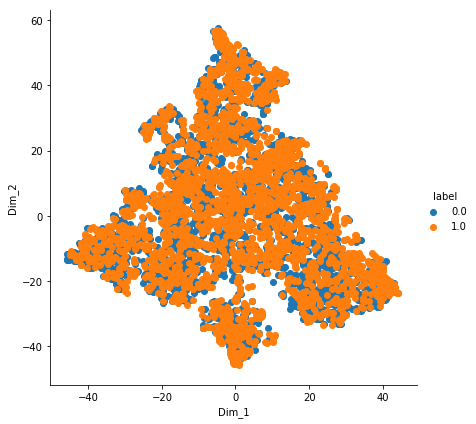

In [35]:
#Source for Multi Core Tsne : https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

#Tsne for 5k data points
data= w2w_tfidf_data_standarize
labels = label_data

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 50
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

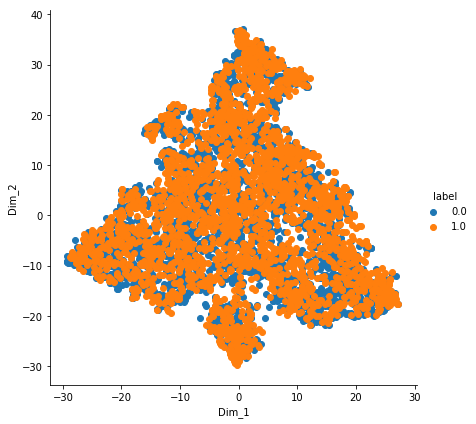

In [36]:
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

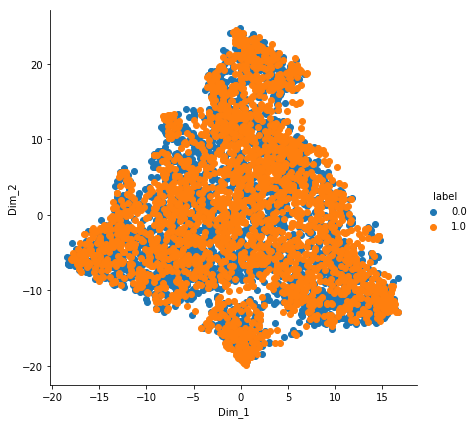

In [37]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 200
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

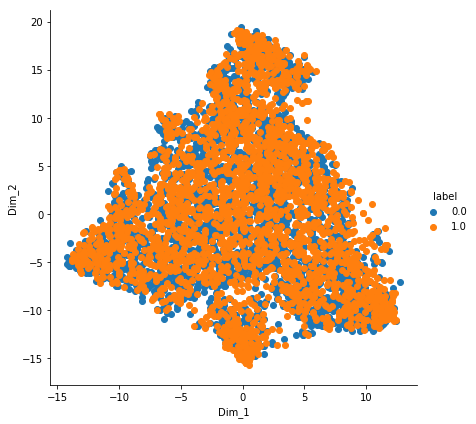

In [38]:
model = TSNE(n_components=2, random_state=0, perplexity=300,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 300
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

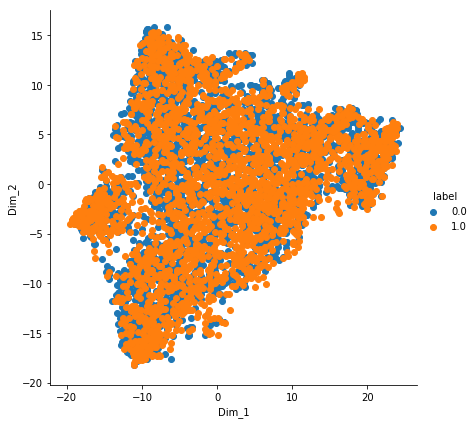

In [39]:
# Using normal TSNE from scikit learn
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=300,  n_iter=5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 300
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


## Applying TNSE on Text Avg W2V vectors

In [40]:
w2w_avg_data_standarize = StandardScaler().fit_transform(sent_vectors)

data=w2w_avg_data_standarize
label_data=sort_data['Score'].head(5000)

w2w_avg_data_standarize.shape

(5000, 50)

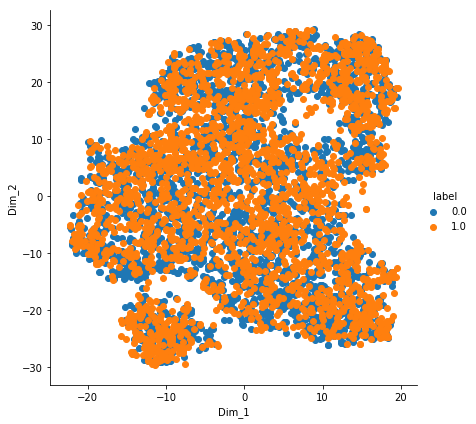

In [41]:
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

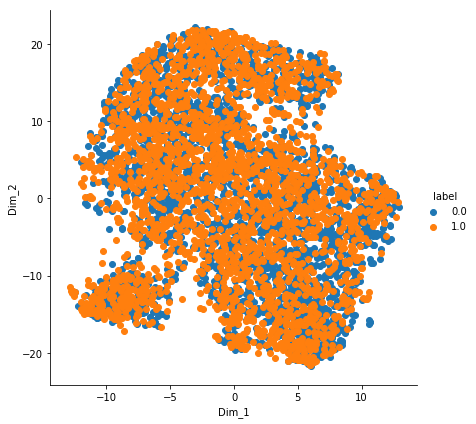

In [42]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 200
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

## Applying TNSE on Text BOW vectors

In [43]:
#TSNE for Bag of words vectorization
bow_tsne=final_counts.toarray() #converting sparse matrix to dense matrix using .toarray()
bow_tsne_data_standarize = StandardScaler().fit_transform(bow_tsne)

data=bow_tsne_data_standarize
label_data=sort_data['Score'].head(5000)

bow_tsne_data_standarize.shape

(5000, 9636)

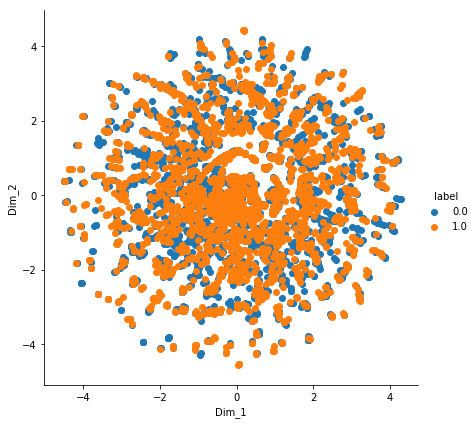

In [44]:
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

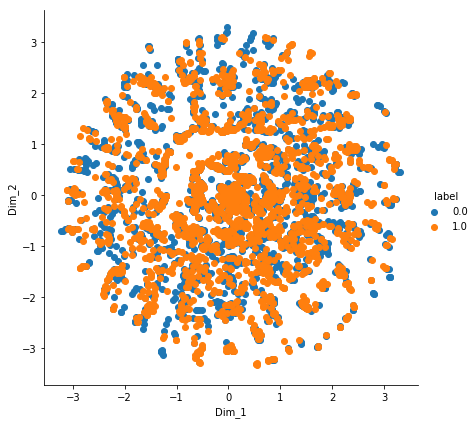

In [45]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=5000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 200
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

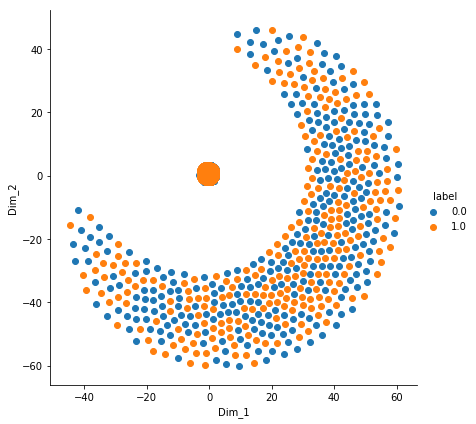

In [46]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=300,  n_iter=5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 300
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


## Applying TNSE on Text TFIDF vectors

In [47]:
# TSNE for TF-IDF Vectorization
tfidf_tsne=final_tf_idf.toarray() #converting sparse matrix to dense matrix using .toarray()
tfidf_tsne_data_standarize = StandardScaler().fit_transform(tfidf_tsne)

data=tfidf_tsne_data_standarize
label_data=sort_data['Score'].head(5000)

tfidf_tsne_data_standarize.shape

(5000, 9636)

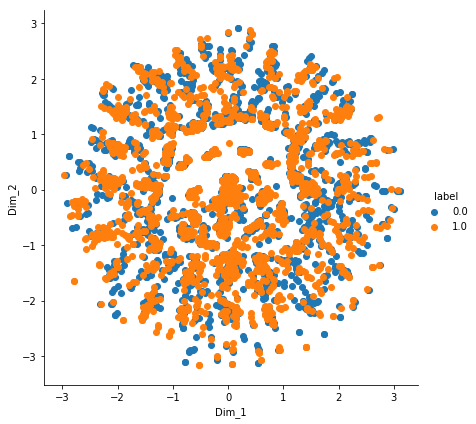

In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=8000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

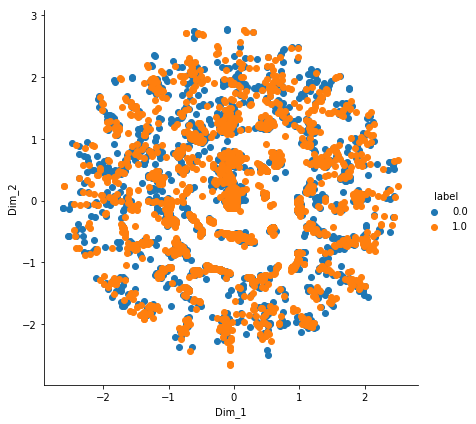

In [49]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=8000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

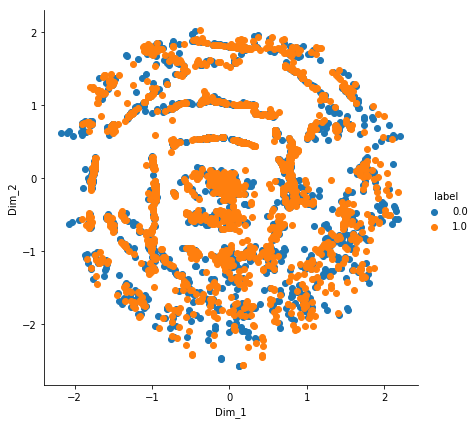

In [50]:
model = TSNE(n_components=2, random_state=0, perplexity=400,  n_iter=8000,n_jobs=8)
# configuring the parameteres
# the number of components = 2
# perplexity = 100
# number of iterations for the optimization = 5000
# number of Jobs = 8

tsne_data = model.fit_transform(data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

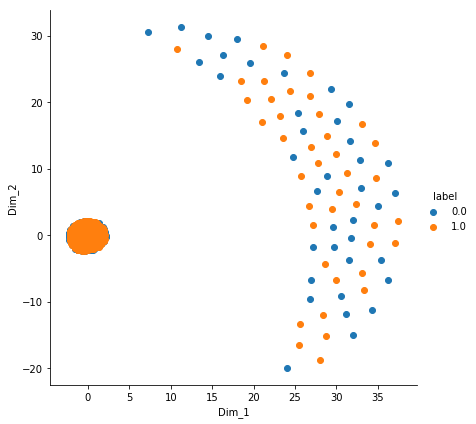

In [51]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=350,  n_iter=8000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 300
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


# Conclusions

Observations :

1.From the above plots for all the vectorization techniques we observe that all the positive and negative points mostly overlap.

2.This behavior does not change much even with different configuraation parameters/ inputs to TSNE i.e. perplexity and number of iterations for the optimization.